In [165]:
import pandas as pd
import json
import openai
import secret
import re

In [166]:
openai.api_key = secret.apiKey

In [167]:
development = pd.read_csv("../data/development.csv")
validation = pd.read_csv("../data/development_test.csv")

In [170]:
# Formateo del dataset de entrenamiento
classes = {
    "0": "moderate_right",
    "1": "moderate_left",
    "2": "right",
    "3": "left"
}
def tokenization(df):
    for c in classes:
        df['completion'] = df['completion'].str.replace(classes[c], c);

In [171]:
gpt3Train = pd.DataFrame({"prompt": development["tweet"] + "\n\n###\n\n", "completion": " " + development["ideology_multiclass"]})
gpt3Validation = pd.DataFrame({"prompt": validation["tweet"] + "\n\n###\n\n", "completion": " " + validation["ideology_multiclass"]})
tokenization(gpt3Train)
tokenization(gpt3Validation)

In [172]:
gpt3Train

,prompt,completion
0,"@user Escribió un libro resultón, con gracejo,...",3
1,@user Lo prometido es deuda. Aquí la foto: .\n...,3
2,@user Bastante ñoña. Me jarté a llorar. De lo ...,3
3,"@user No sé nada acerca de eso, pero está clar...",3
4,"@user ¿En qué medio tienen su podcast esos, di...",3
...,...,...
14395,Lo que está ocurriendo hoy es una forma curios...,0
14396,"@user Gracias, bellísima! Nos debemos un café-...",0
14397,@user Es un análisis muy precipitado ese de qu...,0
14398,Hace días veo en redes cómo algunos se burlan ...,0


In [174]:
gpt3Validation

array([' 3', ' 1', ' 2', ' 0'], dtype=object)

In [175]:
train = json.loads(gpt3Train.to_json(orient='records'))
validation = json.loads(gpt3Validation.to_json(orient='records'))

In [176]:
with open('gpt3-train.jsonl', 'w',encoding='utf-8') as output:
    for entry in train:
        output.write(json.dumps(entry,ensure_ascii=False))
        output.write("\n")

In [177]:
with open('gpt3-validation.jsonl', 'w',encoding='utf-8') as output:
    for entry in validation:
        output.write(json.dumps(entry,ensure_ascii=False))
        output.write("\n")

In [178]:
trainfileid = openai.File.create(
    file=open('gpt3-validation.jsonl', 'rb'),
    purpose='fine-tune'
)["id"]
validationfileid = openai.File.create(
    file=open('gpt3-train.jsonl', 'rb'),
    purpose='fine-tune'
)["id"]

In [179]:
trainevent = openai.FineTune.create(training_file=trainfileid, validation_file=validationfileid, model="ada", compute_classification_metrics = True, classification_n_classes=4)
model_id = trainevent["id"]

In [182]:
trainevent

<FineTune fine-tune id=ft-CohvH8pnxp6ynhTu6IhItzII at 0x252c9b8e450> JSON: {
  "created_at": 1683055652,
  "events": [
    {
      "created_at": 1683055653,
      "level": "info",
      "message": "Created fine-tune: ft-CohvH8pnxp6ynhTu6IhItzII",
      "object": "fine-tune-event"
    }
  ],
  "fine_tuned_model": null,
  "hyperparams": {
    "batch_size": null,
    "classification_n_classes": 4,
    "compute_classification_metrics": true,
    "learning_rate_multiplier": null,
    "n_epochs": 4,
    "prompt_loss_weight": 0.01
  },
  "id": "ft-CohvH8pnxp6ynhTu6IhItzII",
  "model": "ada",
  "object": "fine-tune",
  "organization_id": "org-L1lljxbCYtTHvDgsjfIcJcS5",
  "result_files": [],
  "status": "pending",
  "training_files": [
    {
      "bytes": 808031,
      "created_at": 1683055647,
      "filename": "file",
      "id": "file-Qqg7uKCbyCmU8bGLLekohzNG",
      "object": "file",
      "purpose": "fine-tune",
      "status": "processed",
      "status_details": null
    }
  ],
  "updat

In [185]:
openai.FineTune.list_events(model_id)

<OpenAIObject list at 0x252c71b5a90> JSON: {
  "data": [
    {
      "created_at": 1683055653,
      "level": "info",
      "message": "Created fine-tune: ft-CohvH8pnxp6ynhTu6IhItzII",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1683055706,
      "level": "info",
      "message": "Fine-tune costs $0.39",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1683055706,
      "level": "info",
      "message": "Fine-tune enqueued. Queue number: 6",
      "object": "fine-tune-event"
    }
  ],
  "object": "list"
}

In [119]:
openai.FineTune.list()

<OpenAIObject list at 0x252bb953270> JSON: {
  "data": [
    {
      "created_at": 1681166198,
      "fine_tuned_model": "curie:ft-personal-2023-04-10-23-05-20",
      "hyperparams": {
        "batch_size": 2,
        "learning_rate_multiplier": 0.1,
        "n_epochs": 4,
        "prompt_loss_weight": 0.01
      },
      "id": "ft-8isr7MOodVSaIavj4zlAZHoX",
      "model": "curie",
      "object": "fine-tune",
      "organization_id": "org-L1lljxbCYtTHvDgsjfIcJcS5",
      "result_files": [
        {
          "bytes": 96314,
          "created_at": 1681167921,
          "filename": "compiled_results.csv",
          "id": "file-Hix4jQnfaPfZ1E8vKjOrdUBs",
          "object": "file",
          "purpose": "fine-tune-results",
          "status": "processed",
          "status_details": null
        }
      ],
      "status": "succeeded",
      "training_files": [
        {
          "bytes": 242709,
          "created_at": 1681166122,
          "filename": "file",
          "id": "file-YYP

In [192]:
openai.FineTune.retrieve('ft-CohvH8pnxp6ynhTu6IhItzII')

<FineTune fine-tune id=ft-CohvH8pnxp6ynhTu6IhItzII at 0x252cb939360> JSON: {
  "created_at": 1683055652,
  "events": [
    {
      "created_at": 1683055653,
      "level": "info",
      "message": "Created fine-tune: ft-CohvH8pnxp6ynhTu6IhItzII",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1683055706,
      "level": "info",
      "message": "Fine-tune costs $0.39",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1683055706,
      "level": "info",
      "message": "Fine-tune enqueued. Queue number: 6",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1683055961,
      "level": "info",
      "message": "Fine-tune is in the queue. Queue number: 5",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1683056414,
      "level": "info",
      "message": "Fine-tune is in the queue. Queue number: 4",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1683056535,
      "level": "info",
      "message": "F

In [9]:
id_curie_train_all = 'curie:ft-personal-2023-04-27-12-35-14'

In [193]:
id_ada_train_all = "ada:ft-personal-2023-05-02-20-26-41"
result_ada_file_id = "file-WVdUgvF7Xp0nxx7NDt062pzG"

In [3]:
id_curie_train_1000 = 'curie:ft-personal-2023-04-10-23-05-20'

In [10]:
prediction = openai.Completion.create(
    model=id_curie_train_all,
    prompt="La alianza ibérica y el AVE Madrid-Lisboa son la gran oportunidad que se están perdiendo nuestros dos países y las regiones de Castilla-La Mancha, Castilla y León y Extremadura. Sería un nuevo motor de inversiones y oportunidades para jóvenes, para crecer juntos###"
)

In [195]:
# Descarga y análisis de resultados
content = openai.File.download(result_ada_file_id)

In [197]:
with open('results_ada.csv', 'wb') as file:
    file.write(content)

In [199]:
results = pd.read_csv('results_ada.csv')

<AxesSubplot:>

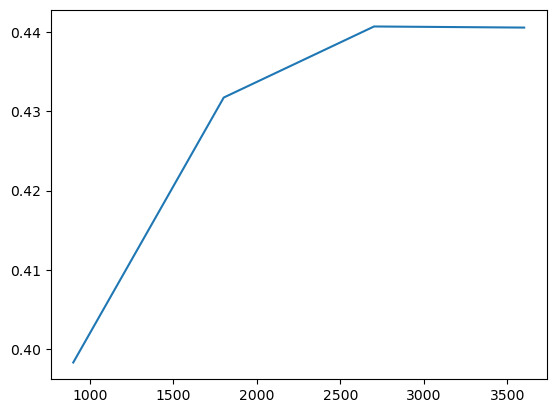

In [205]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

In [11]:
prediction

<OpenAIObject text_completion id=cmpl-7AGXAuSRmG08i0moX14CLcGeYN8eP at 0x15f900df810> JSON: {
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "text": "\n\n moderate_left_right moderate_right_left\n\n moderate_right_"
    }
  ],
  "created": 1682681192,
  "id": "cmpl-7AGXAuSRmG08i0moX14CLcGeYN8eP",
  "model": "curie:ft-personal-2023-04-27-12-35-14",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 16,
    "prompt_tokens": 89,
    "total_tokens": 105
  }
}

## Test del modelo entrenado con 10000 registros

In [4]:
test = pd.read_csv("../data/development_test.csv")

In [5]:
test

,label,gender,profession,ideology_binary,ideology_multiclass,tweet
0,0008c4fab9e97623a60380ee9c88cb20,female,politician,left,left,¡Feliz 28 de febrero a todas las andaluzas y a...
1,0008c4fab9e97623a60380ee9c88cb20,female,politician,left,left,🇩🇪🇪🇸 ¡Un placer encontrarme con mi homólogo al...
2,0008c4fab9e97623a60380ee9c88cb20,female,politician,left,left,La Academia de la Llingua Asturiana realiza un...
3,0008c4fab9e97623a60380ee9c88cb20,female,politician,left,left,Cumplir con la ley y con los derechos laborale...
4,0008c4fab9e97623a60380ee9c88cb20,female,politician,left,left,La contratación indefinida comienza a ser la n...
...,...,...,...,...,...,...
3595,fd249764755c2e64be8aad78d5398953,female,politician,left,left,Esta tarde nos vemos para compartir ideas a pa...
3596,fd249764755c2e64be8aad78d5398953,female,politician,left,left,"@user No sé si te refieres al ""volquete de put..."
3597,fd249764755c2e64be8aad78d5398953,female,politician,left,left,"Desde mañana, este Gobierno seguirá trabajando..."
3598,fd249764755c2e64be8aad78d5398953,female,politician,left,left,"Se nos ha ido Mike Davis, un pensador impresci..."


In [6]:
def predict:

TypeError: string indices must be integers